In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import matplotlib.patches as mpatches
from matplotlib import rcParams
from matplotlib.cm import rainbow
%matplotlib inline

from sklearn.model_selection import train_test_split, StratifiedKFold,cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from statsmodels.tools.eval_measures import rmse
from scipy import stats
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import RFE


In [2]:
travel = pd.read_csv('data.csv')

In [3]:
travel.head()

,ID,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,3433,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,0,7,MALAYSIA,0.0,17.82,NaN,31
1,4339,EPX,Travel Agency,Online,Cancellation Plan,0,85,SINGAPORE,69.0,0.00,NaN,36
2,34590,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,0,11,MALAYSIA,19.8,11.88,NaN,75
3,55816,EPX,Travel Agency,Online,2 way Comprehensive Plan,0,16,INDONESIA,20.0,0.00,NaN,32
4,13816,EPX,Travel Agency,Online,Cancellation Plan,0,10,"KOREA, REPUBLIC OF",15.0,0.00,NaN,29


In [4]:
(travel.groupby('Claim').size()/travel.shape[0]).round(4)

Claim
0    0.9853
1    0.0147
dtype: float64

Text(0.5, 1.0, 'Count of each Target Class')

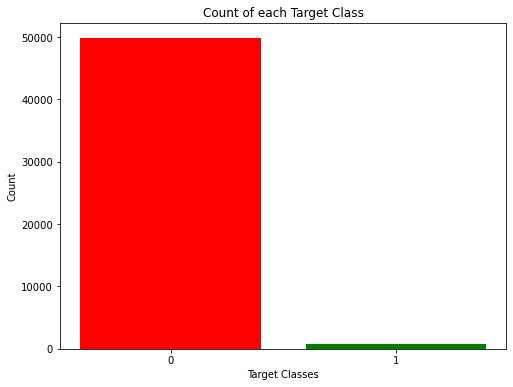

In [5]:
rcParams['figure.figsize']=8,6
plt.bar(travel['Claim'].unique(),travel['Claim'].value_counts(),color=['red','green'])
plt.xticks([0,1])
plt.xlabel('Target Classes')
plt.ylabel('Count')
plt.title('Count of each Target Class')

In [6]:
travel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50553 entries, 0 to 50552
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    50553 non-null  int64  
 1   Agency                50553 non-null  object 
 2   Agency Type           50553 non-null  object 
 3   Distribution Channel  50553 non-null  object 
 4   Product Name          50553 non-null  object 
 5   Claim                 50553 non-null  int64  
 6   Duration              50553 non-null  int64  
 7   Destination           50553 non-null  object 
 8   Net Sales             50553 non-null  float64
 9   Commision (in value)  50553 non-null  float64
 10  Gender                14600 non-null  object 
 11  Age                   50553 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 4.6+ MB


In [7]:
travel.isnull().sum()

ID                          0
Agency                      0
Agency Type                 0
Distribution Channel        0
Product Name                0
Claim                       0
Duration                    0
Destination                 0
Net Sales                   0
Commision (in value)        0
Gender                  35953
Age                         0
dtype: int64

In [8]:
(travel['Gender'].isnull().sum()/travel.shape[0]*100).round(2)

71.12

In [9]:
travel.nunique()

ID                      50553
Agency                     16
Agency Type                 2
Distribution Channel        2
Product Name               25
Claim                       2
Duration                  444
Destination               102
Net Sales                1053
Commision (in value)      964
Gender                      2
Age                        88
dtype: int64

In [10]:
travel.describe()

,ID,Claim,Duration,Net Sales,Commision (in value),Age
count,50553.000000,50553.000000,50553.000000,50553.000000,50553.00000,50553.000000
mean,31679.740134,0.014658,49.425969,40.800977,9.83809,40.011236
std,18288.265350,0.120180,101.434647,48.899683,19.91004,14.076566
min,0.000000,0.000000,-2.000000,-389.000000,0.00000,0.000000
25%,15891.000000,0.000000,9.000000,18.000000,0.00000,35.000000
50%,31657.000000,0.000000,22.000000,26.500000,0.00000,36.000000
75%,47547.000000,0.000000,53.000000,48.000000,11.55000,44.000000
max,63325.000000,1.000000,4881.000000,810.000000,283.50000,118.000000


In [11]:
(travel['Duration']<0).sum()/travel.shape[0]*100

0.005934365913002196

In [12]:
(travel['Duration']>731).sum()/travel.shape[0]*100

0.023737463652008784

In [13]:
(travel['Age']>99).sum()/travel.shape[0]*100

1.572606966945582

In [14]:
def age_convert(age):
    result=''
    if(age <= 21):
        result = 'Child'
    elif(age <= 50):
        result = 'Adult'
    else:
        result = 'Senior'
    return result

In [15]:
def data_pre_processing(df):
    df['Age Group']=df['Age'].map(lambda x: age_convert(x))
    df.drop('Gender',axis = 1,inplace=True)
    df['Duration'][df['Duration']<0]=df['Duration'].median()
    df['Duration'][df['Duration']>731]=731
    df['Age'][df['Age']>99]=df[df['Age Group']=='Senior']['Age'].mean()
    

In [16]:
data_pre_processing(travel)

<ipython-input-15-b97aedf641c2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Duration'][df['Duration']<0]=df['Duration'].median()
<ipython-input-15-b97aedf641c2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Age'][df['Age']>99]=df[df['Age Group']=='Senior']['Age'].mean()


In [17]:
travel.describe()

,ID,Claim,Duration,Net Sales,Commision (in value),Age
count,50553.000000,50553.000000,50553.000000,50553.000000,50553.00000,50553.000000
mean,31679.740134,0.014658,48.553142,40.800977,9.83809,39.191172
std,18288.265350,0.120180,74.721610,48.899683,19.91004,10.598473
min,0.000000,0.000000,0.000000,-389.000000,0.00000,0.000000
25%,15891.000000,0.000000,9.000000,18.000000,0.00000,35.000000
50%,31657.000000,0.000000,22.000000,26.500000,0.00000,36.000000
75%,47547.000000,0.000000,53.000000,48.000000,11.55000,44.000000
max,63325.000000,1.000000,731.000000,810.000000,283.50000,88.000000


In [18]:
travel_plot = travel.drop(['ID','Agency','Agency Type','Destination','Distribution Channel','Product Name','Claim'], axis = 1)

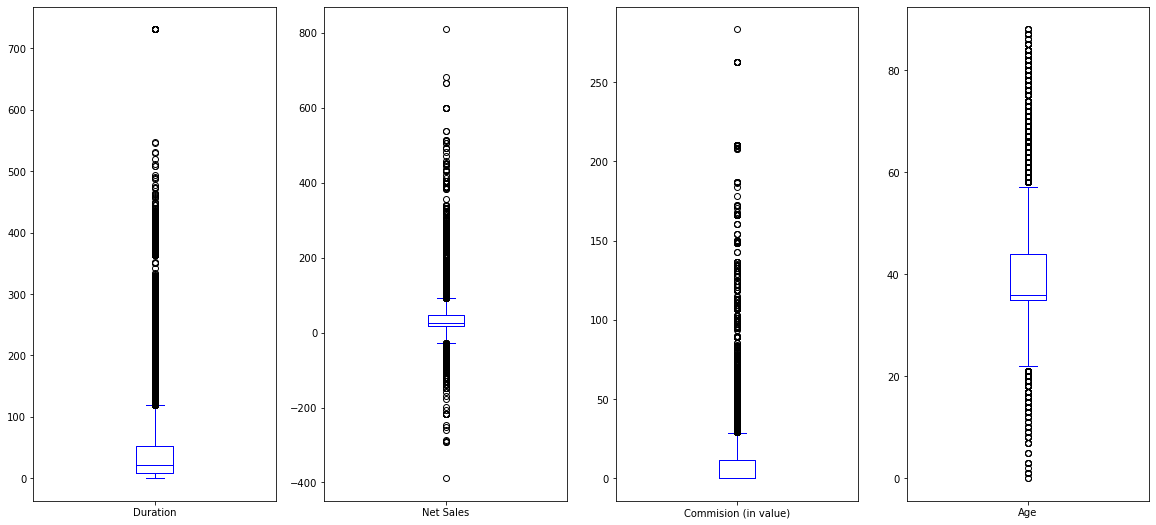

In [19]:
travel_plot.plot(kind='box', subplots=True, layout=(2,4), sharex=False, sharey=False, figsize=(20,20),color='blue')
plt.show()

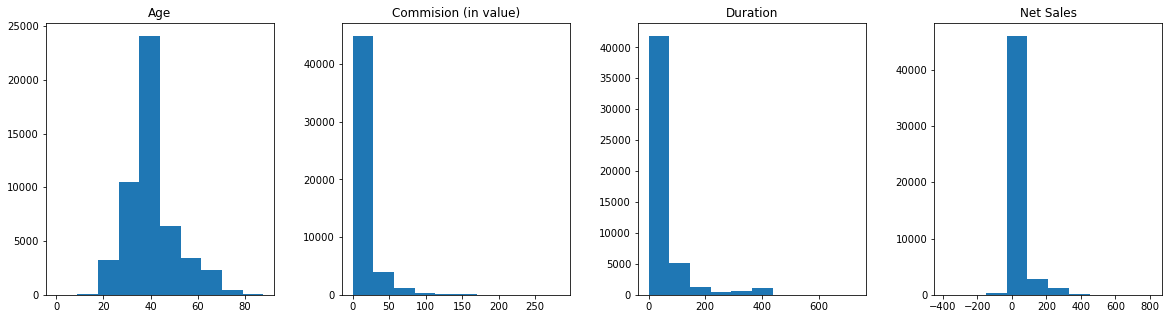

In [20]:
travel_plot.hist(grid=False,sharex=False,sharey=False,figsize=(20,5),layout=(1,4))
plt.show()

In [21]:
Claim_mean = (travel.groupby('Agency', as_index=False)['Claim'].mean()).nlargest(10,'Claim')
Claim_mean

,Agency,Claim
2,C2B,0.066204
11,LWC,0.052920
15,TTW,0.051948
10,KML,0.022082
4,CCR,0.018987
5,CSR,0.014706
3,CBH,0.012346
6,CWT,0.009942
13,SSI,0.005959
7,EPX,0.005428


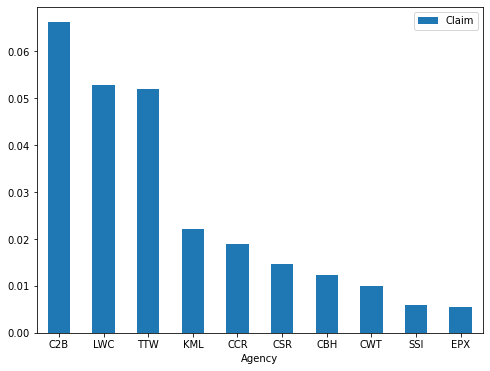

In [22]:
ax = Claim_mean.plot.bar(x='Agency', y='Claim', rot=0)

In [23]:
netsales_mean = (travel.groupby('Agency', as_index=False)['Net Sales'].mean()).nlargest(10,'Net Sales')
netsales_mean

,Agency,Net Sales
11,LWC,115.099088
15,TTW,93.194805
2,C2B,79.253855
10,KML,55.548896
0,ADM,54.301587
8,JWT,54.087459
6,CWT,42.907237
5,CSR,33.808824
7,EPX,32.533248
9,JZI,32.322791


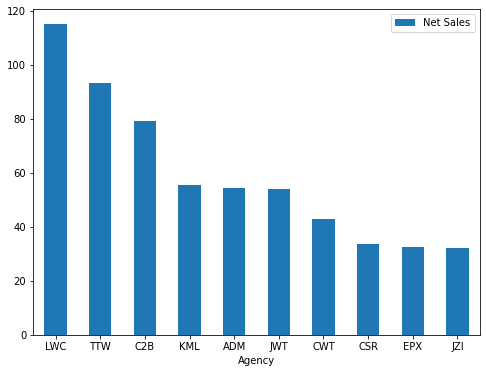

In [24]:
ax1 = netsales_mean.plot.bar(x='Agency', y='Net Sales', rot=0)

Agency     
Claim              0    1
Agency Type              
Airlines       13504  474
Travel Agency  36308  267

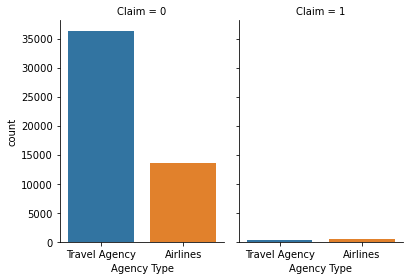

In [25]:
plot2 = sns.catplot(x="Agency Type", col="Claim",data=travel, kind="count",height=4, aspect=.7)
travel.pivot_table(index=['Agency Type'],columns=['Claim'], values=['Agency'], aggfunc='count')

In [26]:
travel.pivot_table(index = ['Product Name'], values = ['Net Sales'], aggfunc = 'mean')

,Net Sales
Product Name,
1 way Comprehensive Plan,27.784366
2 way Comprehensive Plan,42.449914
24 Protect,22.408090
Annual Gold Plan,342.839189
Annual Silver Plan,219.516228
Annual Travel Protect Gold,249.142593
Annual Travel Protect Platinum,335.104444
Annual Travel Protect Silver,197.257534
Basic Plan,26.409049


In [27]:
travel.pivot_table(index = ['Age Group'], values = ['Net Sales'], aggfunc = 'count')

,Net Sales
Age Group,
Adult,42709
Child,623
Senior,7221


In [28]:
travel.groupby('Age Group')['Claim'].value_counts()

Age Group  Claim
Adult      0        42097
           1          612
Child      0          606
           1           17
Senior     0         7109
           1          112
Name: Claim, dtype: int64

<Figure size 288x288 with 0 Axes>

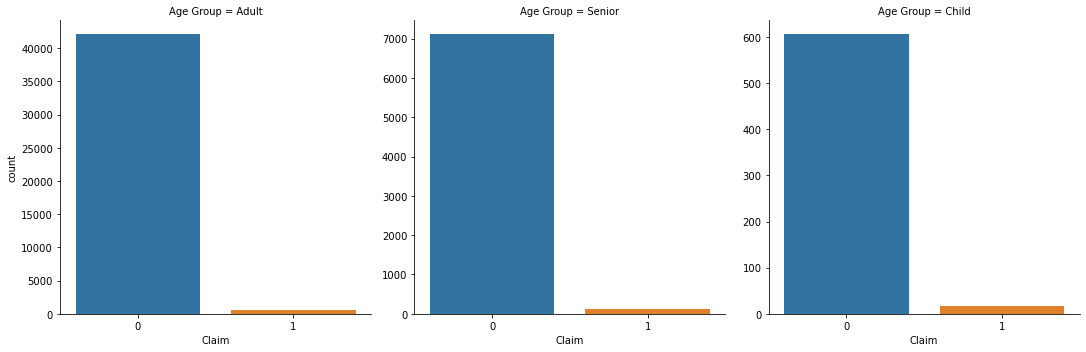

In [29]:
fig = plt.figure(figsize = (4,4))
sns.catplot('Claim', col = 'Age Group', data = travel, col_wrap =3, kind='count',sharey=False)

In [30]:
travel['Destination_risk'] = travel.groupby('Destination')['Claim'].transform('mean')

In [31]:
def Coutry_Categories(value):
    result = ''
    if(value >= 0.3):
        result = '(1) High Risk - More than 30% Claimed'
    elif(value >= 0.2):
        result = '(2) Medium Risk - More than 20% Claimed'
    elif(value > 0):
        result = '(3) Low Risk - More than 1% Claimed'
    else:
        result = '(4) No Risk Countries'
    return result

In [32]:
travel['Risk of Countries'] = travel['Destination_risk'].map(lambda x: Coutry_Categories(x))

In [33]:
travel.head(5)

,ID,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Age,Age Group,Destination_risk,Risk of Countries
0,3433,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,0,7,MALAYSIA,0.0,17.82,31.0,Adult,0.004424,(3) Low Risk - More than 1% Claimed
1,4339,EPX,Travel Agency,Online,Cancellation Plan,0,85,SINGAPORE,69.0,0.00,36.0,Adult,0.042421,(3) Low Risk - More than 1% Claimed
2,34590,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,0,11,MALAYSIA,19.8,11.88,75.0,Senior,0.004424,(3) Low Risk - More than 1% Claimed
3,55816,EPX,Travel Agency,Online,2 way Comprehensive Plan,0,16,INDONESIA,20.0,0.00,32.0,Adult,0.004666,(3) Low Risk - More than 1% Claimed
4,13816,EPX,Travel Agency,Online,Cancellation Plan,0,10,"KOREA, REPUBLIC OF",15.0,0.00,29.0,Adult,0.010998,(3) Low Risk - More than 1% Claimed


In [34]:
travel.head(1)

,ID,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Age,Age Group,Destination_risk,Risk of Countries
0,3433,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,0,7,MALAYSIA,0.0,17.82,31.0,Adult,0.004424,(3) Low Risk - More than 1% Claimed


In [35]:
def feature_processing(df):
    fe = df.groupby('Destination').size()/len(df)
    df.loc[:,'Dest_fe'] = df['Destination'].map(fe)
    fe_1 = df.groupby('Agency').size()/len(df)
    df.loc[:,'Agency_fe'] = df['Agency'].map(fe_1)
    fe_2 = df.groupby('Product Name').size()/len(df)    
    df.loc[:,'Product Name_fe'] = df['Product Name'].map(fe_2)
    df.drop(columns='Agency',axis=1,inplace=True)
    df.drop(columns='Destination',axis=1,inplace=True)
    df.drop(columns='Product Name',axis=1,inplace=True)
    df.drop(columns='Age Group',axis=1,inplace=True)
    df = pd.get_dummies(df, columns=['Agency Type','Distribution Channel'], drop_first=True)

In [36]:
feature_processing(travel)

In [37]:
travel.head(5)

,ID,Agency Type,Distribution Channel,Claim,Duration,Net Sales,Commision (in value),Age,Destination_risk,Risk of Countries,Dest_fe,Agency_fe,Product Name_fe
0,3433,Travel Agency,Online,0,7,0.0,17.82,31.0,0.004424,(3) Low Risk - More than 1% Claimed,0.093901,0.135304,0.135304
1,4339,Travel Agency,Online,0,85,69.0,0.00,36.0,0.042421,(3) Low Risk - More than 1% Claimed,0.209839,0.553914,0.294186
2,34590,Travel Agency,Online,0,11,19.8,11.88,75.0,0.004424,(3) Low Risk - More than 1% Claimed,0.093901,0.135304,0.135304
3,55816,Travel Agency,Online,0,16,20.0,0.00,32.0,0.004666,(3) Low Risk - More than 1% Claimed,0.055110,0.553914,0.207347
4,13816,Travel Agency,Online,0,10,15.0,0.00,29.0,0.010998,(3) Low Risk - More than 1% Claimed,0.023381,0.553914,0.294186


In [38]:
travel.drop(columns=['Risk of Countries'],axis=1,inplace=True)

In [39]:
travel.drop(columns=['Destination_risk'],axis=1,inplace=True)

In [40]:
travel = pd.get_dummies(travel, columns=['Agency Type','Distribution Channel'], drop_first=True)

In [41]:
travel.head(5)

,ID,Claim,Duration,Net Sales,Commision (in value),Age,Dest_fe,Agency_fe,Product Name_fe,Agency Type_Travel Agency,Distribution Channel_Online
0,3433,0,7,0.0,17.82,31.0,0.093901,0.135304,0.135304,1,1
1,4339,0,85,69.0,0.00,36.0,0.209839,0.553914,0.294186,1,1
2,34590,0,11,19.8,11.88,75.0,0.093901,0.135304,0.135304,1,1
3,55816,0,16,20.0,0.00,32.0,0.055110,0.553914,0.207347,1,1
4,13816,0,10,15.0,0.00,29.0,0.023381,0.553914,0.294186,1,1


In [42]:
X = travel.drop('Claim', axis = 1)
Y = travel['Claim']

In [43]:
def plot_heatmap(df, fig_size=(10, 7)):
    fig = plt.figure(figsize=fig_size)
    sns.heatmap(df.corr(), annot=True)
    plt.show()

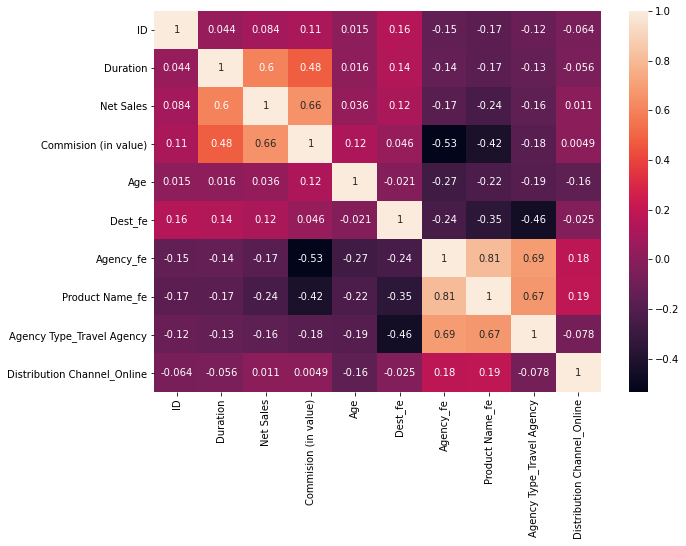

In [44]:
plot_heatmap(X)

In [45]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size = 0.7, random_state = 7)

In [46]:
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)
y_pred_rf = rf.predict(X_test)
print(accuracy_score(Y_test, y_pred_rf))
print(classification_report(Y_test, y_pred_rf))

0.9851641830410128
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     14949
           1       0.32      0.03      0.06       217

    accuracy                           0.99     15166
   macro avg       0.65      0.52      0.53     15166
weighted avg       0.98      0.99      0.98     15166



In [47]:
logr = LogisticRegression()
logr.fit(X_train,Y_train)
y_pred = logr.predict(X_test)
print(accuracy_score(Y_test, y_pred))
print(classification_report(Y_test, y_pred))

0.9852960569695371
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     14949
           1       0.00      0.00      0.00       217

    accuracy                           0.99     15166
   macro avg       0.49      0.50      0.50     15166
weighted avg       0.97      0.99      0.98     15166

